## Vectorized Matrix Factorization

This implementation is identical to matrix-factorization-ex1.ipynb, but we will use NumPy vectors to significantly improve efficiency and decrease training time. Remember that NumPy provides optimized data structures for multi-dimensional arrays and efficient methods for operating on this data.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.utils import shuffle

## Load Data

In [2]:
# edited_rating.csv is created in the user-user-cf-example.ipynb
ratings = pd.read_csv('../../data/movielens/edited_rating.csv')
ratings.shape

(20000263, 4)

In [3]:
ratings.head(2)

,userId,movieId,rating,movie_idx
0,0,2,3.5,2
1,0,29,3.5,29


### Take a Subset of Data

Since computation is significantly faster in vector form, we will use a slightly larger subset.

Then we can compare results to previous experiments, and determine if additional data improved our test set MSE.

In [6]:
N = ratings.userId.max() + 1
M = ratings.movie_idx.max() + 1
print(f'Original data: {N} users, {M} movies')

Original data: 138493 users, 26744 movies


In [7]:
n = 10000
m = 4000
print(f'Taking a sample with the top {n} users and the top {m} movies')

Taking a sample with the top 10000 users and the top 4000 movies


In [8]:
# identify the top n userIds and top m movieIds

user_counter = Counter(ratings.userId)
movie_counter = Counter(ratings.movie_idx)

top_users = [user for (user, count) in user_counter.most_common(n)]
top_movies = [movie for (movie, count) in movie_counter.most_common(m)]

mask = (ratings.userId.isin(top_users)) & (ratings.movie_idx.isin(top_movies))

df = ratings.loc[mask]

print(f'Subset of data has shape {df.shape}')

Subset of data has shape (6678949, 4)


In [9]:
# re-define user and movie id mappings

new_user_ids = {}
i = 0
for old in top_users:
    new_user_ids[old] = i
    i += 1
    
df.loc[:, 'userId'] = df.apply(lambda row: new_user_ids[row.userId], axis=1)


new_movie_ids = {}
j = 0
for old in top_movies:
    new_movie_ids[old] = j
    j += 1

df.loc[:, 'movie_idx'] = df.apply(lambda row: new_movie_ids[row.movie_idx], axis=1)

/Users/jujohnson/anaconda3/envs/tf.latest/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Create Train/ Test Split

In [10]:
N = df.userId.max() + 1
M = df.movie_idx.max() + 1

df = shuffle(df)

cutoff = int(0.8*len(df))

df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [11]:
print(f'Training set shape {df_train.shape}')
print(f'Test set shape {df_test.shape}')

Training set shape (5343159, 4)
Test set shape (1335790, 4)


## Create Data Structures for Train / Test

In [ ]:
# map users -> list of movies ated
user2movie = {}

# map movies -> list of users who have rated
movie2user = {}

# map user-movie pairs -> ratings
usermovie2rating = {}

for counter, (idx, row) in enumerate(df_train.iterrows()):
    if counter % 1e5 == 0:
        print(f'Processing {counter}')
        
    userId, movieId, rating, movie_idx = row
    userId, movieId, movie_idx = int(userId), int(movieId), int(movie_idx)

    usermovie2rating[(userId, movie_idx)] = rating

    if userId not in user2movie:
        user2movie[userId] = []
    user2movie[userId].append(movie_idx)

    if movie_idx not in movie2user:
        movie2user[movie_idx] = []
    movie2user[movie_idx].append(userId)

In [ ]:
# map user-movie pairs -> ratings
usermovie2rating_test = {}

for counter, (idx, row) in enumerate(df_test.iterrows()):
    if counter % 1e5 == 0:
        print(f'Processing {counter}')
    userId, movieId, rating, movie_idx = row
    userId, movieId, movie_idx = int(userId), int(movieId), int(movie_idx)
    usermovie2rating_test[(userId, movie_idx)] = rating

We introduce one new data structure in order to allow for vectorized computation.

This new dictionary will map each user to a vector of (movieId, rating) pairs, so that we can easily look up all movies rated by user *i*.

In [58]:
# new data structs for training data
user2movierating = {}
for user, movies in user2movie.items():
    rating = np.array([usermovie2rating[(user, movie)] for movie in movies])
    user2movierating[user] = (movies, rating)
movie2userrating = {}
for movie, users in movie2user.items():
    rating = np.array([usermovie2rating[(user, movie)] for user in users])
    movie2userrating[movie] = (users, rating)

print('Train set finished')

# new data structs for test set - will speed up MSE calculation
movie2userrating_test = {}
for (user, movie), rating in usermovie2rating_test.items():
    if movie not in movie2userrating_test:
        movie2userrating_test[movie] = [[user], [rating]]
    else:
        movie2userrating_test[movie][0].append(user)
        movie2userrating_test[movie][1].append(rating)
for movie, (users, rating) in movie2userrating_test.items():
    movie2userrating_test[movie][1] = np.array(rating)
    
print('Test set finished')

Train set finished
Test set finished


## Initialize Params

In [59]:
N = int(np.max(list(user2movie.keys())) + 1)

# the test set may contain movies the train set doesn't have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = int(max(m1, m2) + 1)

print(f'N: {N}, M: {M}')

N: 10000, M: 4000


In [60]:
# K latent dimensions
K = 10

# Item matrix and bias 
W = np.random.randn(N, K)
b = np.zeros(N)

# User matrix and bias
U = np.random.randn(M, K)
c = np.zeros(M)

mu = np.mean(list(usermovie2rating.values()))

## Define Loss

In [61]:
def get_mse(movie2userratings):
    '''
    d: movie2userratings dictionary
    movie_id -> (user_ids, ratings)
    '''
    N = 0
    sse = 0
    for movie, (users, ratings) in movie2userratings.items():
        predictions = W[users].dot(U[movie]) + b[users] + c[movie] + mu
        delta = predictions - ratings
        sse += delta.dot(delta)
        N += len(ratings)
    return sse / N

## Train Model

In [62]:
from datetime import datetime

In [ ]:
epochs = 25
reg_penalty = 20

train_losses = []
test_losses = []

for epoch in range(epochs):
    print(f'Starting epoch {epoch}')
    
    epoch_start = datetime.now()
    
    # update W and b
    t0 = datetime.now()
    # for each user
    for userId in range(N):
        movies, rating = user2movierating[userId]
        # update W and b
        matrix = U[movies].T.dot(U[movies]) + np.eye(K)*reg_penalty
        vector = (rating - b[userId] - c[movies] - mu).dot(U[movies])
        bi = (rating - U[movies].dot(W[userId]) - c[movies]- mu).sum()
        
        W[userId] = np.linalg.solve(matrix, vector)
        b[userId] = bi / (len(user2movie[userId]) + reg_penalty)
        
        if userId % (N//10) == 0:
            print(f'userId: {userId}, N: {N}')

    print(f'Updated W and b in {datetime.now() - t0}')
    

    # update U and c 
    t0 = datetime.now()
    for movieId in range(M):
        try:
            userIds, ratings = movie2userrating[movieId]
            matrix = W[userIds].T.dot(W[userIds]) + np.eye(K) + reg_penalty
            vector = (ratings - b[userIds] - c[movieId] - mu).dot(W[userIds])
            cj = (ratings - W[userIds].dot(U[movieId]) - b[userIds] - mu).sum()
            
            U[movieId] = np.linalg.solve(matrix, vector)
            c[movieId] = cj / (len(movie2user[movieId]) + reg_penalty)

            if movieId % (M//10) == 0:
                print(f'movieId: {movieId}, M: {N}')
        except KeyError:
            pass

    print(f'Upated U and c in {datetime.now() - t0}')
    print(f'Epoch time: {datetime.now() - epoch_start}')
    
    
    t0 = datetime.now()
    train_losses.append(get_mse(movie2userrating))
    print(f'Loss time: {datetime.now() - t0}')
    print(f'Train loss: {train_losses[-1]}')
    test_losses.append(get_mse(movie2userrating_test))
    print(f'Test loss: {test_losses[-1]}')

## Plot Loss

In [64]:
import matplotlib.pyplot as plt

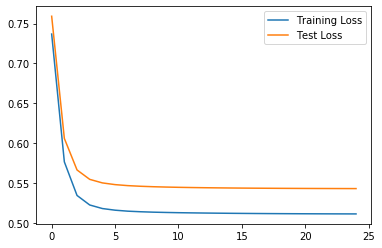

In [65]:
plt.plot(train_losses, label='Training Loss');
plt.plot(test_losses, label='Test Loss');
plt.legend()
plt.show()

We can see that these results are much better than previous matrix factorization results. This is because we have more than doubled the size of our training set.

We were able to increase training set because computation is much more efficient in vectorized form. Thanks NumPy.